In [240]:
# find Stopwords for Hinglish- remove min_df,max_df
# Try compressing the songs first and then pass to word2vec
# Trends in songs over the years
# Find the topics on which songs are focused
# 
!pip install wordcloud

In [15]:
import pandas as pd
import numpy as np
import nltk
import gensim 
from gensim.models.phrases import Phrases, Phraser
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import operator
from collections import defaultdict

In [16]:
data=pd.read_csv("mergedData.csv")

In [17]:
data = data.sort_values(by=['years'], ascending= False)

In [18]:
data.head(2)

,movieName,songName,songSinger,songMusic,songLyricist,songLyrics,years
0,Bala,Don’t Be Shy,"Badshah, Shalmali Kholgade, Gurdeep Mehendi",Sachin-Jigar,"Mellow D, Badshah","Sun, main hoon thoda sanki\r\nKarun mann ki\r\...",2019
174,Bharat,Chashni,Abhijeet Srivastava,Vishal-Shekhar,Irshad Kamil,(Mitthi mitthi)\r\n\r\nZubaan hai pheeki shaam...,2019


In [5]:
# data['songLyrics'][0].split("\n")

# nltk.download('punkt')
doc=[]
for i in range(data.shape[0]):
    doc.append(nltk.word_tokenize(re.sub('[^a-zA-z\s]','',data['songLyrics'][i].lower())))


In [6]:
count_words = {}
for x in doc:
    for y in x:
        if count_words.get(y)==None:
            count_words[y] = 0
        count_words[y]+=1


In [7]:
sorted_weight = sorted(count_words.items(), key=lambda x:x[1], reverse = True
       )
stopWords = sorted_weight[:300]

def column(matrix, index):
    x = []
    for y in matrix:
        x.append(y[index])
    return x
stopWords = column(stopWords,0)
stopWords[:10]

['hai', 'mein', 'na', 'tu', 'ke', 'ho', 'main', 'se', 'ki', 'dil']

#### Doc with removed stop words
> format of doc : 

In [248]:
# nltk.download('punkt')
doc=[]
for i in range(data.shape[0]):
    doc.append(set([x for x in nltk.word_tokenize(re.sub('[^a-zA-z\s]','',data['songLyrics'][i].lower())) if x not in stopWords]))

# Bag of words approach

In [249]:
strr=""
for i in doc[:1000]:
    for j in i:
        strr=strr+' '+ j

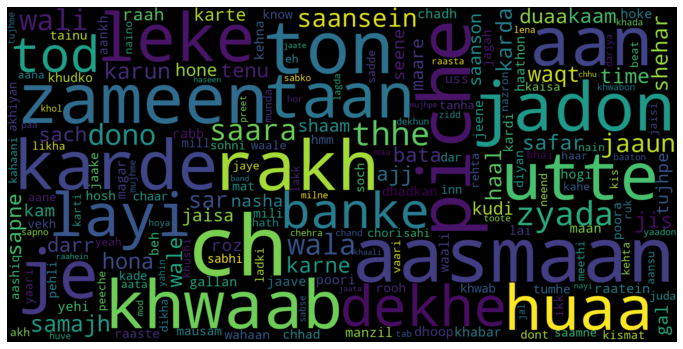

In [250]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(strr)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

> Word cloud for songs after 2010

In [251]:
strr=""
for i in doc[3300:4480]:
    for j in i:
        strr=strr+' '+ j

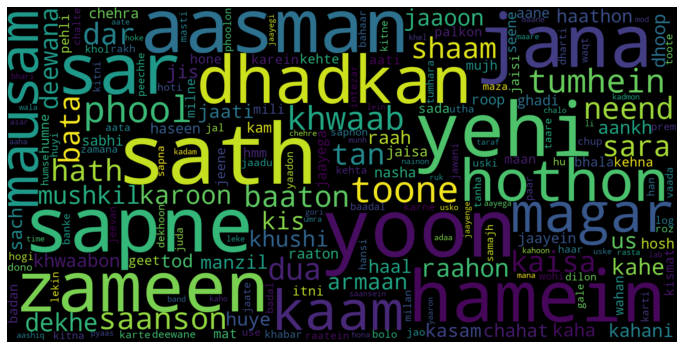

In [252]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(strr)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

> Word Cloud of Songs before 2000

### Finding the word rank over the years

> To do: Remove stop words ( atleast 100) and then find ranks

> Do on a set of (list of words ) instead of taking all the repetitions

In [253]:
# for every year, create a list of dictionary
# every dictionary has word and frequency count
# create a global list of words and frequency count as well

In [254]:
data[data.years == 2019]["songLyrics"]

0      Sun, main hoon thoda sanki\r\nKarun mann ki\r\...
174    (Mitthi mitthi)\r\n\r\nZubaan hai pheeki shaam...
161    Haa haah...\r\n\r\nBaatein zaroori hain\r\nTer...
162    Yeh aaina hai ya tu hai\r\nJo roz mujhko sanwa...
163    Meri raahein tere tak hain\r\nTujhpe hi toh me...
                             ...                        
92     Haa hmm...\r\n\r\nDard woh kaafi na tha\r\nJo ...
88     Ye jo hai tere mere darmiyaan\r\nIshq ki hai y...
89     Cutie pie, cutie pie\r\nCutie pie, cutie pie (...
90     Aa....\r\n\r\nAa... de re na...\r\nAa...\r\n\r...
80     Ghunghta utha ke mila le tu akhiyaan\r\nKehne ...
Name: songLyrics, Length: 253, dtype: object

In [12]:
# get all the songs for a year
# return type list ( song1, song2 , ...., songN)
def getSongsForYear(dataframe, columnNameWithYear = "years", year = "2019", songLyricsColumn = "songLyrics"):
    return list(dataframe[data[columnNameWithYear] == year]["songLyrics"])

# preprocesses a single song and returns a song as output
def songPreprocessing(song):
    listOfWords = re.split(r'[;,\s...\n()\'!?.]\s*',song)
    processedSong = ''
    for word in listOfWords:
        word = word.lower()
        if word == 'x2':
            continue
        if word == 'x4':
            continue
        if word == '':
            continue
        processedSong+=word+' '
    return processedSong
def processDataFrame(data):
    allSongs=[]
    for year in data.years.unique():
        songs = getSongsForYear(data, "years", year, "songLyrics")
        for mySong in songs:
            # preprocess the songs
            mySong = songPreprocessing(mySong)
            allSongs.append(mySong)
    return allSongs
        

In [19]:
# create an english dictionary 
englishWords = {}
df = pd.read_excel("wordlist60k.xlsx") # once we have the data
listOfWords = list(df.a)
for word in listOfWords:
    englishWords[word] = True
# now get the words in the dataset
allSongs = processDataFrame(data)
englishWordsData = {}
for song in allSongs:
    l = song.split(" ")
    for word in  l:
        if englishWords.get(word) != None:
            englishWordsData[word] = True
        
        

In [21]:
len(englishWordsData)

4508

In [22]:
import operator
# assigns ranks for a year to the words
# input dictionary for a year { word: frequency}
# output  dictionary {word: rank} 
def assignRankToWords(d):
    sortedListOfWords = sorted(d.items(), key = operator.itemgetter(1), reverse = True)
    rankDictionary = {}
    currentRank = 0
    
    # [('hai', 1664),
    #      ('tu', 848),
    #      ('main', 817)] sample sorted list of words
    # since words are reverse sorted so :
    for pair in sortedListOfWords:
        word = pair[0]
        rank = currentRank
        rankDictionary[word] = rank
        currentRank+=1
    return rankDictionary

        

# generate year wise word frequency count in all songs
# input  = data ( songs data)
# output = List of 2 dictionaries [dictionary ( { year : {word: frequency}}  ), globalRankDictionary (year , {word: rank}) ]
def createWordFreqCountPerYear(data):
    listOfDictionary = []
    gDict = {}
    gRankDictionary = {}
    for year in data.years.unique():
        songs = getSongsForYear(data, "years", year, "songLyrics")
        d = {}
        for mySong in songs:
            # preprocess the songs
            mySong = songPreprocessing(mySong)
            listOfWords = mySong.split(" ")
            for word in (listOfWords): # use set here as well
                if d.get(word) == None: 
                    d[word] = 0
                d[word]+=1
        # assign rank to words
        rankDictionary = assignRankToWords(d)
        gRankDictionary[year] = rankDictionary
        gDict[year] = d
            

    return [gDict, gRankDictionary]
#     listOfDictionary.append(gDict)
    

gDict, gRankDictionary = createWordFreqCountPerYear(data) # global dictionary



In [23]:
sorted(gDict[2019].items(), key = operator.itemgetter(1), reverse = True)[:10]

[('hai', 1664),
 ('tu', 848),
 ('main', 817),
 ('na', 788),
 ('mein', 695),
 ('ho', 659),
 ('ki', 600),
 ('dil', 596),
 ('ke', 591),
 ('se', 535)]

In [24]:
import operator
wordFreqDict = gDict[2019]
sorted( wordFreqDict.items(), key=operator.itemgetter(1), reverse = True)[:10]

[('hai', 1664),
 ('tu', 848),
 ('main', 817),
 ('na', 788),
 ('mein', 695),
 ('ho', 659),
 ('ki', 600),
 ('dil', 596),
 ('ke', 591),
 ('se', 535)]

In [25]:
# Word rank for a year
# input  dictionary ( { year : {word: rank}}  ) , word
# output is word rank of a word in several years [ list (year, rank)]
def getWordRanks(gRankDictionary = gRankDictionary, word = "ladki"):
    retList = []
    for year in gRankDictionary.keys():
        if year == 0 :
            continue
        d = gRankDictionary[year]
        if(d.get(word) == None):
            retList.append([year, 1])
        else:
            retList.append([year, d[word]/len(d)])
    
    return retList

# let's merge some of these years and take a moving average

# Use: averages 2d matrix (year: values) to 2d matrix (year/4, average(values) over 4 years)
# input, 2d matrix , years to average on (even numbers 0, 2 , 4 ...)
# output is 2d matrix
def average2DMatrixOverTime(myList, yearNumberToAverage ):
    yearCounter = 0
    averagedList = []
    myYear = 0
    numberYearAverage = yearNumberToAverage
    movingAverage = 0
    for x in myList:
    #     print(x)
        year = x[0]
        rank = x[1]
        movingAverage+=rank
        if(yearCounter == int(numberYearAverage/2)):
            myYear = year


        if yearCounter == numberYearAverage:
            averagedList.append([myYear, movingAverage/numberYearAverage])
            yearCounter = 0
            movingAverage = 0

        yearCounter+=1
    return averagedList

# gets column in a n-Dimensional matrix
def column(matrix, index):
    x = []
    for y in matrix:
        x.append(y[index])
            
    return x

word1 = "paisa"
word2 = "ladki"
myList = getWordRanks(gRankDictionary, word1)
myList2 = getWordRanks(gRankDictionary, word2)
myList = sorted(myList,key= operator.itemgetter(0), reverse = False)
myList2 = sorted(myList2,key= operator.itemgetter(0), reverse = False)

In [26]:
averagedList = average2DMatrixOverTime(myList, 4)
averagedList2 = average2DMatrixOverTime(myList2, 4)
# averagedList = sorted(averagedList,key= operator.itemgetter(0), reverse = True)
# averagedList2 = sorted(averagedList2,key= operator.itemgetter(0), reverse = True)
len(column(averagedList,0))

17

Do singlePlot = True to plot or plt.show() to Print
Do singlePlot = True to plot or plt.show() to Print


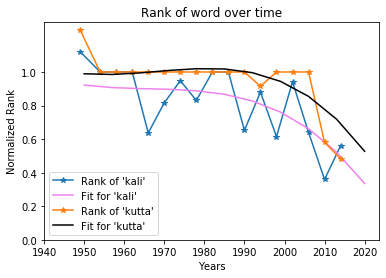

In [72]:
# Input a word and get yearwise rank of the word

#input the word and chart is  ploted automatically 
def plotRankChart(word, gRankDictionary, fitPolynomialDegree = -1, fitPolynomial_X_list = np.array(range(0,1,4)), singlePlot = False, polyFitColor = '' ):
    myList = getWordRanks(gRankDictionary, word)
    myList = sorted(myList,key= operator.itemgetter(0), reverse = False)
    averagedList = average2DMatrixOverTime(myList, 4)
#     sns.lineplot(column(averagedList, 0), column(averagedList, 1),  marker = '*', dashes = False, label = "Rank of \'"+word+"\'")
    
    plt.plot(column(averagedList, 0), column(averagedList, 1),  marker = '*',  label = "Rank of \'"+word+"\'")

    if(fitPolynomialDegree != -1 and fitPolynomialDegree!=0):
        x = fitPolynomial_X_list
        x_knots = column(myList, 0)
        y_knots = column(myList, 1)
        poly_deg = 3
        coefs = np.polyfit(x_knots, y_knots, poly_deg)
        y_poly = np.polyval(coefs, x)

        # plt.scatter(x_knots, y_knots, "o", label="data points")
        if(polyFitColor == ''):
            plt.plot(x, y_poly, label = "Fit for '"+word+"\'")
        else:
            plt.plot(x, y_poly, polyFitColor,  label = "Fit for '"+word+"\'")
    if(singlePlot == True):
        plt.show()
    else:
        print("Do singlePlot = True to plot or plt.show() to Print")
        
        
plotRankChart("kali", gRankDictionary, 3, np.array(range(1950, 2022, 7)), singlePlot = False, polyFitColor='violet')
plotRankChart("kutta", gRankDictionary, 3, np.array(range(1950, 2022, 7)), singlePlot = False, polyFitColor='black')

plt.xticks([x for x in range(1940, 2021, 10)])
plt.yticks([x/10 for x in range(0, 11, 2)])

plt.xlabel("Years")
plt.ylabel("Normalized Rank")
plt.title("Rank of word over time")
plt.legend()
plt.show()

In [ ]:
wordRanks3d = []
for word in englishWordsData:
    wordRanks3d.append(getWordRanks(gRankDictionary, word))
    
# average the word ranks over the years
len(wordRanks3d)

In [39]:
temp = getWordRanks(gRankDictionary, "ladki")
len(temp)

72

No handles with labels found to put in legend.


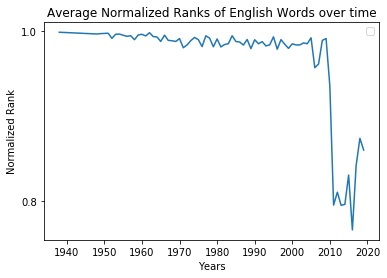

In [58]:
# output [[2019: hello], [2018: hi], [2017: hamara]]
wordRanks3d[2][0]
averageRanksOfEnglishWordsOverYears = []
for i in range(len(temp)):
    year = 0
    rankSum = 0
    
    for j in range(len(wordRanks3d)):
        year = wordRanks3d[j][i][0]
        rank = wordRanks3d[j][i][1]
        rankSum+=rank
#         print(wordRanks3d[j][i])
        # sum up all the ranks
        
    rankSumAverage = rankSum/len(wordRanks3d)
    averageRanksOfEnglishWordsOverYears.append([year, rankSumAverage])
averageRanksOfEnglishWordsOverYears

plt.plot(column(averageRanksOfEnglishWordsOverYears, 0), column(averageRanksOfEnglishWordsOverYears,1))
plt.xticks([x for x in range(1940, 2021, 10)])
plt.yticks([x/10 for x in range(8, 12, 2)])

plt.xlabel("Years")
plt.ylabel("Normalized Rank")
plt.title("Average Normalized Ranks of English Words over time")
plt.legend()
plt.savefig("EnglishWordsRanksOverTime.png")

plt.show()
# plotRankChart(averageRanksOfEnglishWordsOverYears, gRankDictionary, 3,  np.array(range(1950, 2022, 7)), singlePlot = False, polyFitColor='violet')

No handles with labels found to put in legend.


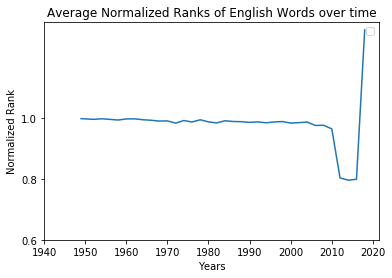

In [53]:
averagedListOfEnglishWords4Years = average2DMatrixOverTime(averageRanksOfEnglishWordsOverYears, 2)

plt.plot(column(averagedListOfEnglishWords4Years, 0), column(averagedListOfEnglishWords4Years,1))
plt.xticks([x for x in range(1940, 2021, 10)])
plt.yticks([x/10 for x in range(6, 11, 2)])

plt.xlabel("Years")
plt.ylabel("Normalized Rank")
plt.title("Average Normalized Ranks of English Words over time")
plt.legend()
plt.show()

In [ ]:
# how to code for english words in hindi transcript


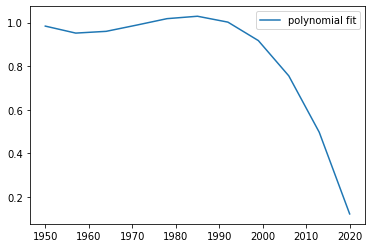

In [212]:
x = np.array(range(1950, 2022, 7))

x_knots = column(myList, 0)
y_knots = column(myList,1)

poly_deg = 3
coefs = np.polyfit(x_knots, y_knots, poly_deg)
y_poly = np.polyval(coefs, x)

# plt.scatter(x_knots, y_knots, "o", label="data points")
plt.plot(x, y_poly, label="polynomial fit")
plt.legend()

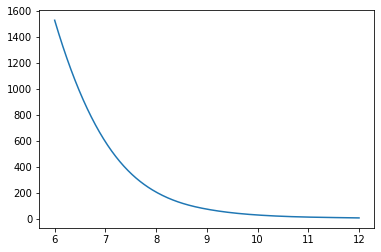

In [75]:
from scipy.interpolate import make_interp_spline, BSpline

T = np.array([6, 7, 8, 9, 10, 11, 12])
power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(T.min(), T.max(), 300) 

spl = make_interp_spline(T, power, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [9]:
train=[]
for i in doc:
    strr=""
    for j in i:
        strr=strr+' '+j
    train.append(strr)
    

In [10]:
count_vec=CountVectorizer(max_features=10000,ngram_range=(1,3),min_df=0.01,max_df=0.9)
features=count_vec.fit_transform(train)

In [11]:
len(count_vec.get_feature_names())

1470

In [12]:
count_vec.get_feature_names()

['aa',
 'aa aa',
 'aa gaya',
 'aa gayi',
 'aadat',
 'aadha',
 'aadhi',
 'aag',
 'aage',
 'aah',
 'aaj',
 'aaja',
 'aake',
 'aan',
 'aana',
 'aane',
 'aankh',
 'aankhein',
 'aankhen',
 'aankhon',
 'aankhon ke',
 'aankhon ki',
 'aankhon mein',
 'aankhon se',
 'aansu',
 'aao',
 'aap',
 'aarzoo',
 'aas',
 'aashiq',
 'aasmaan',
 'aata',
 'aata hai',
 'aate',
 'aati',
 'aati hai',
 'aaun',
 'aave',
 'aaya',
 'aaya hai',
 'aaye',
 'aayega',
 'aayi',
 'aayi hai',
 'ab',
 'ab na',
 'ab toh',
 'ab tu',
 'abb',
 'abhi',
 'adaa',
 'ae',
 'agar',
 'ai',
 'aisa',
 'aise',
 'aisi',
 'ajj',
 'ajnabi',
 'akh',
 'akhaan',
 'akhiyan',
 'alag',
 'all',
 'allah',
 'am',
 'and',
 'andar',
 'andhera',
 'andhere',
 'apna',
 'apne',
 'apni',
 'are',
 'arey',
 'armaan',
 'arrey',
 'asar',
 'assi',
 'aur',
 'aye',
 'baad',
 'baadal',
 'baahein',
 'baahon',
 'baahon mein',
 'baaki',
 'baal',
 'baap',
 'baaqi',
 'baar',
 'baar baar',
 'baari',
 'baarish',
 'baat',
 'baat hai',
 'baatein',
 'baaton',
 'baaton mein'

In [13]:
sw=count_vec.get_stop_words()

In [14]:
sw

# TF-IDF

In [15]:
tvec = TfidfVectorizer(max_features=50000, ngram_range=(1,3))
featuress=tvec.fit_transform(train)



In [16]:
# tvec.get_feature_names()

# Word2vec

In [65]:
# build vocabulary and train model
w2v_model = gensim.models.Word2Vec(doc,size=300,window=15,min_count=2,workers=10,iter=10)
 

In [66]:
w2v_model.wv.most_similar(positive=["ladki"],topn=30)

[('pagli', 0.7821118235588074),
 ('bhadki', 0.7595430612564087),
 ('hirni', 0.7511991262435913),
 ('bholi', 0.748058021068573),
 ('kiski', 0.7388608455657959),
 ('tikhi', 0.7388180494308472),
 ('nakhrezi', 0.7334308624267578),
 ('uski', 0.7300316095352173),
 ('shaamat', 0.7281936407089233),
 ('hasina', 0.7224459648132324),
 ('tabiyat', 0.6981139183044434),
 ('bolti', 0.6946688890457153),
 ('choti', 0.6923705339431763),
 ('tezi', 0.6907729506492615),
 ('kharaab', 0.6846696138381958),
 ('padti', 0.6836082339286804),
 ('taisi', 0.6815592050552368),
 ('gutli', 0.6792900562286377),
 ('sanwali', 0.677106499671936),
 ('iski', 0.6770094633102417),
 ('komalkomal', 0.6769245862960815),
 ('nagin', 0.6753458976745605),
 ('ladka', 0.6745123863220215),
 ('chull', 0.6695646047592163),
 ('buddhi', 0.6657022833824158),
 ('masti', 0.6637625694274902),
 ('naadaan', 0.6631249189376831),
 ('halki', 0.6612765789031982),
 ('mastani', 0.6612482070922852),
 ('seedhi', 0.6572535037994385)]

In [67]:
w2v_model.wv.most_similar(positive=["maa"])

[('aanchal', 0.6763774156570435),
 ('sehmasehma', 0.6629800200462341),
 ('iski', 0.6402838230133057),
 ('pet', 0.6309642195701599),
 ('baap', 0.6082305908203125),
 ('naachna', 0.6014535427093506),
 ('khudki', 0.5980710387229919),
 ('fauji', 0.595901608467102),
 ('perplex', 0.5905705690383911),
 ('khedaaya', 0.59029221534729)]

In [68]:
w2v_model.wv.most_similar(positive=["papa"])

[('bajaye', 0.7780275344848633),
 ('setting', 0.693885087966919),
 ('waalon', 0.6874403357505798),
 ('nachungi', 0.6846287250518799),
 ('akad', 0.6797761917114258),
 ('footpath', 0.6767768859863281),
 ('daalo', 0.6712957620620728),
 ('naachegi', 0.6646528244018555),
 ('india', 0.6636440753936768),
 ('khench', 0.6584562063217163)]

In [69]:
w2v_model.wv.most_similar(positive=["girl","ladki"])

[('hasina', 0.8013215661048889),
 ('hirni', 0.7869861125946045),
 ('tezi', 0.7866613864898682),
 ('start', 0.7688995599746704),
 ('nakhrezi', 0.7681745290756226),
 ('adayein', 0.7587242126464844),
 ('padti', 0.7565988898277283),
 ('blowing', 0.750407874584198),
 ('chandu', 0.7408386468887329),
 ('jaari', 0.7407184839248657)]

In [70]:
w2v_model.wv.most_similar(positive="disco")

[('khisko', 0.8220754861831665),
 ('tamanche', 0.8025801181793213),
 ('floor', 0.7932847738265991),
 ('limit', 0.7811633944511414),
 ('nasheelee', 0.7743369936943054),
 ('beat', 0.7661519646644592),
 ('baiyaan', 0.7598690986633301),
 ('thumke', 0.7582615613937378),
 ('dynamite', 0.7461631298065186),
 ('anarkali', 0.7436412572860718)]

In [71]:
w2v_model.wv.most_similar(positive="dil")

[('khatara', 0.5460834503173828),
 ('sifarisho', 0.5255773663520813),
 ('dhadke', 0.5221536159515381),
 ('banjara', 0.5191588401794434),
 ('bechara', 0.5142488479614258),
 ('pehal', 0.5131976008415222),
 ('patanga', 0.4994124174118042),
 ('agar', 0.49296894669532776),
 ('badmash', 0.49168843030929565),
 ('lathkhor', 0.49166038632392883)]

In [72]:
w2v_model.wv.similarity(w1="girl",w2="dress")

0.6114609484429677

In [73]:
# model.wv.vocab

In [30]:
# word_freq = defaultdict(int)
# for i in doc:
#     for j in i:
#         word_freq[j] += 1
# len(word_freq)

In [31]:
# sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [32]:
# w2v_model = gensim.models.Word2Vec(min_count=20,
#                      window=2,
#                      size=300,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,)
# w2v_model.build_vocab(doc)

In [33]:
# w2v_model.train(doc, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

In [34]:
# w2v_model.wv.most_similar(positive=["ladki"],topn=30)

In [35]:
# w2v_model.wv.doesnt_match(['ladki', 'munda', 'girl'])

In [36]:
# t-SNE Visualization 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.
# For that we are going to use t-SNE implementation from scikit-learn.

In [74]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()
    
# To make the visualizations more relevant, we will look at the relationships between a query 
# word (in **red**), its most similar words in the model (in **blue**), 
# and other words from the vocabulary (in **green**).


    

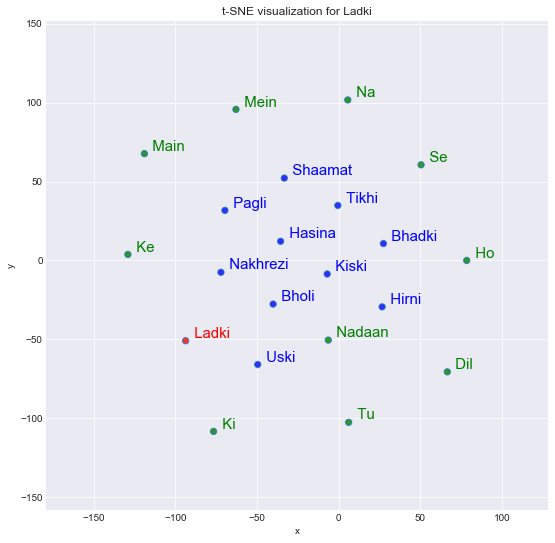

In [75]:
tsnescatterplot(w2v_model, 'ladki', ['nadaan', 'tu', 'main', 'mein', 'ho', 'na', 'ke', 'se', 'ki', 'dil'])

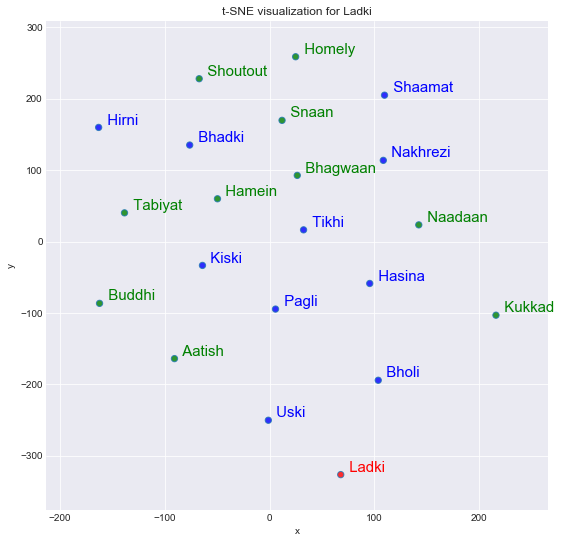

In [76]:
tsnescatterplot(w2v_model, 'ladki', [i[0] for i in w2v_model.wv.most_similar(positive=["ladka"])])

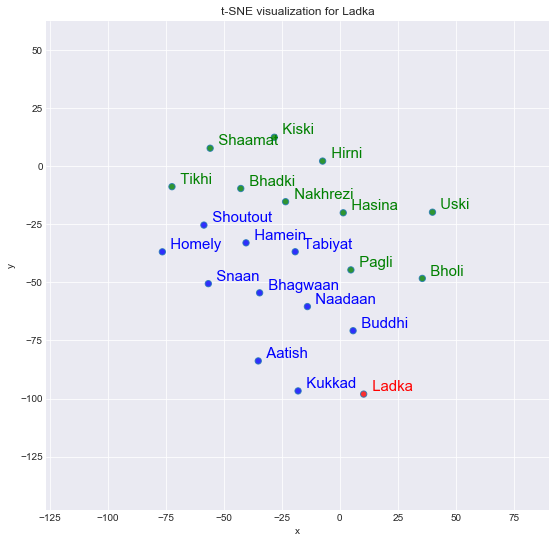

In [77]:
tsnescatterplot(w2v_model, 'ladka', [i[0] for i in w2v_model.wv.most_similar(positive=["ladki"])])

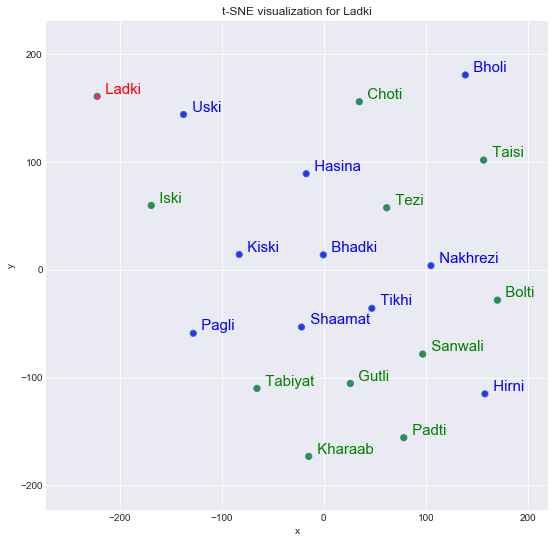

In [78]:
tsnescatterplot(w2v_model, "ladki", [t[0] for t in w2v_model.wv.most_similar(positive=["ladki"], topn=20)][10:])

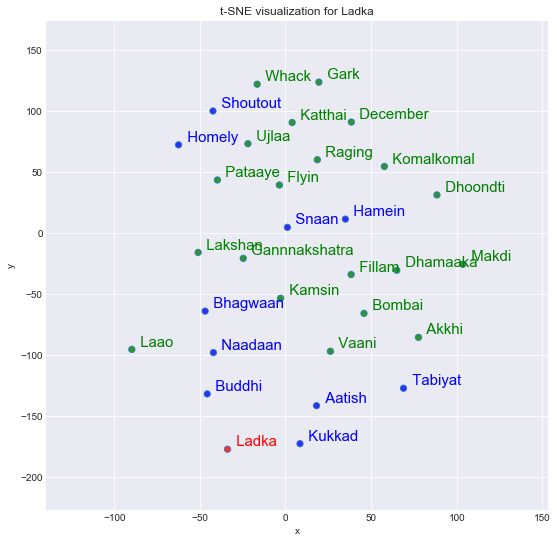

In [79]:
tsnescatterplot(w2v_model, "ladka", [t[0] for t in w2v_model.wv.most_similar(positive=["ladka"], topn=30)][10:])

In [57]:
# finding the window size for the songs
for line in data.songLyrics[246].split("\n"):
    print(line)

Ho yeh khabar chhapwa do akhbaar mein
Poster lagwa do baazaar mein
Ho… yeh khabar chhapwa do akhbaar mein
Ho ek ladka, ek ladki
Ek ladka, ek ladki
Ek ladka ladki, ladka ladki, ladka ladki…
Dhoondne ko pyar mein
Ghooma hoon gali gali
Tu jo mil gayi
Dhoondne ko pyar mein
Ghoomi hoon gali gali
Tu jo mil gaya
Ab jo mile hain tum
Aa ho jayein khalli balli
Yeh na ho phans jaaye
Yeh na ho phans jaaye
Yeh na ho, na ho, na ho… jaaye jaaye…
Akhbaar hua purana baby online de do news
Ki main teri mehbooba
Aur tu hai mera muse
Le le credit card
Tu aaj hi karle choose shadi destination wali
Aajkal tere mere pyaar ke charche
Har jubaan pe chori
Sabko maloom pad gaya
Teri mummy ko nahi tension
Tere papa ka main pension
Tu le le na attention
Chori pagal kyun hori
O yeh khabar chhapwa do akhbaar mein
Poster lagwa do baazaar mein
Yeh khabar chhapwa do akhbaar mein
Haan ek ladka, ek ladki
Ek ladka, ek ladki
Ek ladka ladki, ladka ladki, ladka ladki…
Ho dono paagal ho gaye pyar mein


In [66]:
# Preprocessing function
def songPreprocessing(song):
    listOfWords = re.split(r'[;,\s...\n()\'!?.]\s*',song)
    processedSong = ''
    for word in listOfWords:
        word = word.lower()
        if word == 'x2':
            continue
        if word == 'x4':
            continue
        processedSong+=word
        processedSong+=' '
    return processedSong

averageChorusLength = 0
count = 0
for i in range(0, len(data)):
    count+=1
    averageChorusLengthForSong = 0
    numWords = 0
    chorusCount = 0
#     print(i , " is :  ")
    for line in data.songLyrics[i].split('\n'):
#         print(len(songPreprocessing(line).split(' '))) 
#         print(line)
        numWords+=len(songPreprocessing(line).split(' '))-1
        if(len(line) == 0):
#             print("yes")
            averageChorusLengthForSong+=numWords
            numWords = 0
            chorusCount+=1
    averageChorusLengthForSong/=(chorusCount+1) # account for the last chorus
    if(averageChorusLengthForSong == 0):
        count-=1
        continue
#     print(averageChorusLengthForSong)
    averageChorusLength += averageChorusLengthForSong
    
averageChorusLength/=count
    
print(averageChorusLength)
    
# averageChorusLength/=1
# print(averageChorusLength)

23.667168235914335


### Hence the average optimal window size for the songs is 23.667 or 24 words